# Author: Mikita Sazanovich

In [1]:
import os
import random
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from kaldi.feat.mfcc import Mfcc, MfccOptions
from kaldi.matrix import SubVector, SubMatrix
from kaldi.util.options import ParseOptions
from kaldi.util.table import SequentialWaveReader, SequentialMatrixReader, MatrixWriter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

from tqdm import tqdm_notebook as tqdm

In [2]:
NUM_PEOPLE = 10

np.random.seed(7)

train_wav_paths = []
train_classes = []
test_wav_paths = []
test_classes = []
wav_dir = os.path.join('VCTK-Corpus', 'wav48')
persons = sorted(os.listdir(wav_dir))[:NUM_PEOPLE]
for num, person in enumerate(persons):
    person_dir = os.path.join(wav_dir, person)
    wav_names = list(map(lambda wav_name: os.path.join(person_dir, wav_name), os.listdir(person_dir)))
    train_person_speech, test_person_speech = train_test_split(wav_names, test_size=0.2)
    train_wav_paths.extend(train_person_speech)
    train_classes.extend([num] * len(train_person_speech))
    test_wav_paths.extend(test_person_speech)
    test_classes.extend([num] * len(test_person_speech))
print('Number of people={}'.format(NUM_PEOPLE))
print('train:', len(train_wav_paths), len(train_classes))
print('test:', len(test_wav_paths), len(test_classes))

Number of people=10
train: 2966 2966
test: 749 749


In [3]:
def write_descriptor(wav_paths, desc_path):
    with open(desc_path, 'w') as output:
        for wav_path in wav_paths:
            output.write('{} {}\n'.format(wav_path, wav_path))
            
train_desc_path = 'train_desc.scp'
test_desc_path = 'test_desc.scp'
write_descriptor(train_wav_paths, train_desc_path)
write_descriptor(test_wav_paths, test_desc_path)

In [4]:
def compute_kaldi_features(desc_path, output_path, samp_freq=8000):
    print('Started processing', desc_path)
    rspec, wspec = 'scp:{}'.format(desc_path), 'ark:{}'.format(output_path)
    
    mfcc_opts = MfccOptions()
    mfcc_opts.frame_opts.samp_freq = samp_freq

    mfcc = Mfcc(mfcc_opts)
    sf = mfcc_opts.frame_opts.samp_freq
    
    with SequentialWaveReader(rspec) as reader, MatrixWriter(wspec) as writer: 
        for key, wav in reader:
            assert(wav.samp_freq >= sf)
            assert(wav.samp_freq % sf == 0)

            s = wav.data()
            s = s[:,::int(wav.samp_freq / sf)]
            m = SubVector(mean(s, axis=0))

            f = mfcc.compute_features(m, sf, 1.0)
            f = SubMatrix(scale(f))
            writer[key] = f
    print('Success! Result is written to', output_path)

In [5]:
train_kaldi_path = 'train_kaldi.ark'
test_kaldi_path = 'test_kaldi.ark'
compute_kaldi_features(train_desc_path, train_kaldi_path)
compute_kaldi_features(test_desc_path, test_kaldi_path)

Started processing train_desc.scp
Success! Result is written to train_kaldi.ark
Started processing test_desc.scp
Success! Result is written to test_kaldi.ark


In [6]:
def read_features(kaldi_path):
    features = []
    rspec = 'ark:{}'.format(kaldi_path)
    with SequentialMatrixReader(rspec) as reader:
        for key, mat in reader:
            features.append(torch.tensor(mat, dtype=torch.float))
    return features

train_features = read_features(train_kaldi_path)
test_features = read_features(test_kaldi_path)

In [7]:
print('Train:', len(train_features), len(train_classes))
print('Test:', len(test_features), len(test_classes))

Train: 2966 2966
Test: 749 749


In [8]:
class SpeakerIdentityLSTM(nn.Module):
    
    def __init__(self, feature_dim, hidden_dim, num_classes):
        super(SpeakerIdentityLSTM, self).__init__()
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(feature_dim, hidden_dim, num_layers=1)
        
        self.hidden2class = nn.Linear(hidden_dim, num_classes)
        self.hidden = None
        self.softmax = nn.LogSoftmax(dim=1)
        
    def __init_hidden(self, batch_size):
        # The axes semantics are (num_layers, batch_size, hidden_dim)
        return (torch.zeros(1, batch_size, self.hidden_dim).cuda(),
                torch.zeros(1, batch_size, self.hidden_dim).cuda())
    
    def __get_class_scores(self, batch, lengths):
        self.hidden = self.__init_hidden(batch.size(0))
        packed_input = pack_padded_sequence(batch, lengths, batch_first=True)
        outputs, (ht, ct) = self.lstm(packed_input, self.hidden)
        class_scores = self.hidden2class(ht[-1])
        
        return class_scores
    
    def forward(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        output = self.softmax(class_scores)
        
        return output
    
    def predict_classes(self, batch, lengths):
        class_scores = self.__get_class_scores(batch, lengths)
        classes = class_scores.argmax(dim=1)
        
        return classes

In [9]:
current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

GeForce GTX 1080 Ti


In [10]:
def pack_feature_class_lists(features, classes, ids):
    ids = sorted(ids, key=lambda ind: features[ind].size(0), reverse=True)
    lengths = list(map(lambda ind: features[ind].size(0), ids))
    seq = list(map(lambda ind: features[ind], ids))
    inputs = pad_sequence(seq, batch_first=True).cuda()
    targets = torch.tensor(list(map(lambda ind: classes[ind], ids)), dtype=torch.long)
    return inputs, lengths, targets

def train_lstm(train_features, train_classes, test_features, test_classes):
    EPOCHS = 5000
    BATCH_SIZE = 1024
    HIDDEN_DIM = 64

    torch.manual_seed(7)
    np.random.seed(7)

    model = SpeakerIdentityLSTM(train_features[0].shape[1], HIDDEN_DIM, NUM_PEOPLE).cuda()
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)

    N_train = len(train_features)
    N_test = len(test_features)
    train_ids = list(range(N_train))
    test_ids = list(range(N_test))

    train_losses = []
    test_accuracies = []

    for epoch in tqdm(range(EPOCHS)):
        np.random.shuffle(train_ids)
    
        model.train()
        train_loss = 0
        for i in range(0, N_train, BATCH_SIZE):
            model.zero_grad()
            train_inputs, train_lens, train_targets = pack_feature_class_lists(
                train_features, train_classes, train_ids[i:i+BATCH_SIZE])
            class_log_probs = model(train_inputs, train_lens).cpu()
            loss = criterion(class_log_probs, train_targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_losses.append(train_loss)

        model.eval()
        correct = 0
        for i in range(0, N_test, BATCH_SIZE):
            test_inputs, test_lens, test_targets = pack_feature_class_lists(
                test_features, test_classes,test_ids[i:i+BATCH_SIZE])
            test_predictions = model.predict_classes(test_inputs, test_lens).cpu()
            correct += (test_predictions == test_targets).sum().item()
        accuracy = 100 * correct / N_test
        test_accuracies.append(accuracy)
    return train_losses, test_accuracies

In [11]:
train_kaldi_losses, test_kaldi_accuracies = train_lstm(
    train_features, train_classes, test_features, test_classes)

In [91]:
def smooth(scalars, weight=0.9):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

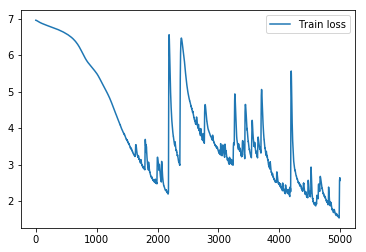

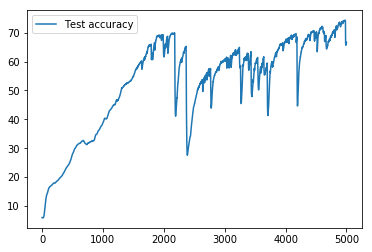

In [92]:
plt.plot(range(len(train_kaldi_losses)), smooth(train_kaldi_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_kaldi_accuracies)), smooth(test_kaldi_accuracies))
plt.legend(['Test accuracy'])
plt.show()

In [13]:
noised_wav_dir = os.path.join('VCTK-Corpus', 'noised')
assert os.path.exists(noised_wav_dir)
train_noised_paths = []
for train_wav_path in train_wav_paths:
    head, filename = os.path.split(train_wav_path)
    _, dirname = os.path.split(head)
    train_noised_path = os.path.join(noised_wav_dir, dirname, filename)
    assert os.path.exists(train_noised_path)
    train_noised_paths.append(train_noised_path)
train_noised_desc_path = 'train_noised_desc.scp'
write_descriptor(train_noised_paths, train_noised_desc_path)

In [14]:
train_kaldi_noised_path = 'train_noised_kaldi.ark'
compute_kaldi_features(train_noised_desc_path, train_kaldi_noised_path)
train_noised_features = read_features(train_kaldi_noised_path)

Started processing train_noised_desc.scp
Success! Result is written to train_noised_kaldi.ark


In [55]:
AUTO_HID = 13

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder, self).__init__()
        self._encoder = nn.Sequential(
            nn.Linear(13, 64),
            nn.Tanh(),
            nn.Linear(64, AUTO_HID),
            nn.Tanh())
        self._decoder = nn.Sequential(
            nn.Linear(AUTO_HID, 64),
            nn.Tanh(),
            nn.Linear(64, 13))

    def encode(self, x):
        return self._encoder(x)

    def decode(self, x):
        return self._decoder(x)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [81]:
def train_autoencoder(noised_features, features):
    AUTO_EPOCHS = 100
    BATCH_SIZE = 1024
    
    torch.manual_seed(7)
    np.random.seed(7)

    autoencoder = Autoencoder().cuda()
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.SGD(autoencoder.parameters(), lr=1e-9)

    xs = []
    ys = []
    for noised_feature, feature in zip(noised_features, features):
        for i in range(noised_feature.shape[0]):
            xs.append(noised_feature[i].numpy())
            ys.append(feature[i].numpy())

    N_train = len(xs)
    print('Total pairs for denoising:', N_train)
    train_ids = list(range(N_train))

    auto_train_losses = []

    for epoch in tqdm(range(AUTO_EPOCHS)):
        np.random.shuffle(train_ids)

        autoencoder.train()
        train_loss = 0.0
        for i in range(0, N_train, BATCH_SIZE):
            ids = train_ids[i:i+BATCH_SIZE]
            seq = list(map(lambda ind: xs[ind], ids))
            X_batch = torch.tensor(seq, dtype=torch.float).cuda()
            Y_pred = autoencoder(X_batch).cpu()
            seq = list(map(lambda ind: ys[ind], ids))
            Y_batch = torch.tensor(seq, dtype=torch.float)
            loss = criterion(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        auto_train_losses.append(train_loss)
    autoencoder.eval()
    return autoencoder.cpu(), auto_train_losses

In [82]:
autoencoder, autoencoder_losses = train_autoencoder(train_noised_features, train_features)

Total pairs for denoising: 1054069


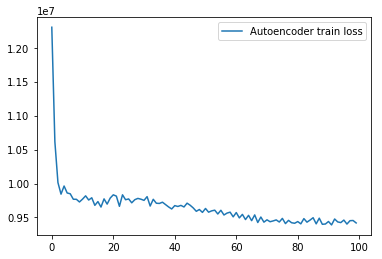

In [83]:
plt.plot(range(len(autoencoder_losses)), autoencoder_losses)
plt.legend(['Autoencoder train loss'])
plt.show()

In [84]:
def compute_auto_features(features_all):
    auto_features_all = []
    for features in features_all:
        K = features.shape[0]
        auto_features = []
        for k in range(K):
            auto_features.append(autoencoder.encode(features[k]).detach())
        auto_features_all.append(torch.stack(auto_features))
    return auto_features_all

train_auto_features = compute_auto_features(train_features)
test_auto_features = compute_auto_features(test_features)

In [85]:
train_auto_losses, test_auto_accuracies = train_lstm(
    train_auto_features, train_classes, test_auto_features, test_classes)

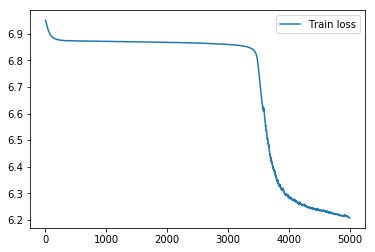

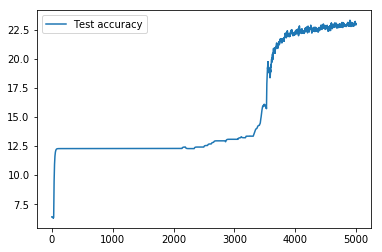

In [93]:
plt.plot(range(len(train_auto_losses)), smooth(train_auto_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_auto_accuracies)), smooth(test_auto_accuracies))
plt.legend(['Test accuracy'])
plt.show()

In [87]:
def build_merged_features(features1_all, features2_all):
    merged_features_all = []
    for features1, features2 in zip(features1_all, features2_all):
        merged_features = torch.cat((features1, features2), dim=1)
        merged_features_all.append(merged_features)
    return merged_features_all

train_merged_features = build_merged_features(train_features, train_auto_features)
test_merged_features = build_merged_features(test_features, test_auto_features)

In [88]:
train_merged_losses, test_merged_accuracies = train_lstm(
    train_merged_features, train_classes, test_merged_features, test_classes)

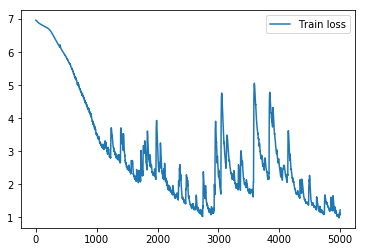

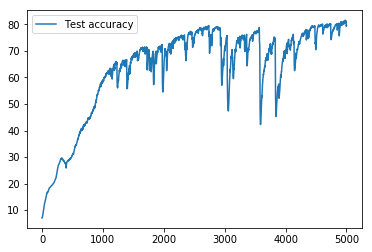

In [94]:
plt.plot(range(len(train_merged_losses)), smooth(train_merged_losses))
plt.legend(['Train loss'])
plt.show()

plt.plot(range(len(test_merged_accuracies)), smooth(test_merged_accuracies))
plt.legend(['Test accuracy'])
plt.show()

# Ablation study results

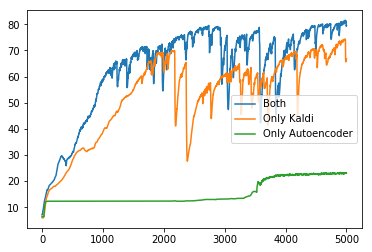

In [95]:
plt.plot(range(len(test_merged_accuracies)), smooth(test_merged_accuracies))
plt.plot(range(len(test_kaldi_accuracies)), smooth(test_kaldi_accuracies))
plt.plot(range(len(test_auto_accuracies)), smooth(test_auto_accuracies))
plt.legend(['Both', 'Only Kaldi', 'Only Autoencoder'])
plt.show()